# NeuroTracker CDA Analysis

In [1]:
import numpy as np
import pandas as pd
import glob
import pickle

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf

import collections
from autoreject import AutoReject

sys.path.append('/Users/nick/Documents/PhD/CLCT/InLook/NeuroTracker/')
from cda_utils import get_epochs, get_CDA, prep_report, fill_report, get_report, checksum, add_cda_report, get_CDA_perf_report
#from events import get_specific_events

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# 0 - General Info

In [3]:
#==================================================================
# General Variables
#==================================================================
# Organize Triggers
trigger = 2

# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
# 

# T2 = T1 + 5s 
# T4 = T2 + 2s
# T8 = T4 + 9s ?! (9s ?)
# T16 = T8 + ~1s
# T32 = T8 + 25s   ensuite un autre 3s plus tard.

# Beaucoup de 1 et 32.. pas clair...

# --------------------------
conds = ['1', '2', '3']
sides = ['Right', 'Left', 'ClassicMod']
perfs = ['good', 'bad']

new_events_value = dict()
new_events_value['1'] = 100
new_events_value['2'] = 200
new_events_value['3'] = 300
new_events_value['Right'] = 10
new_events_value['Left'] = 20
new_events_value['ClassicMod'] = 30
new_events_value['good'] = 1
new_events_value['bad'] = 2

report = prep_report(conds, sides, perfs)

# CDA Channels
chan_right = ['PO8', 'PO4', 'P8']
chan_left = ['PO7', 'PO3', 'P7']

# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.6)

# CDA main variable!
cda_dict = dict()
cda_dict_clean = dict()
epochs_dict = dict()

## 1. Prep Data

In [5]:
#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
directory_path = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/'

for filepath in glob.iglob(directory_path + '*.bdf'):
    filename = filepath[filepath.rfind('/')+1:]
    print('Processing: ' + filename + '...')

    # 1. -- Load File --
    raw = read_raw_bdf(filepath, preload=True)

    # 2. -- General Preprocess --
    # Keep only EEG channels and reference
    raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
    raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
    raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

    # Set Electrodes Locations
    montage = mne.channels.make_standard_montage('biosemi64')
    raw.set_montage(montage)

    # Resample
    preproc = raw.resample(500)

    # Filter
    preproc = preproc.filter(.1, 30., fir_design='firwin', skip_by_annotation='edge')

    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    events = find_events(preproc)
    new_events = copy.deepcopy(events) # Copy of events that we'll modify to assign different triggers to use for concatening epochs
    
    frequency = collections.Counter(events[:,2])
    events_frequency = dict(frequency)
    print('Max Events in File...')
    print("---------------------------")
    for e in set(events[:,2]):
        print("{}: \t\t{}".format(e, frequency[e]))
    print("---------------------------")

    df_behav = pd.read_csv(directory_path + filename[:filename.rfind('.')] + '.csv', sep=',')
    
    specific_events = dict()
    for cond in conds:
        specific_events[cond] = dict()
        for side in sides:
            specific_events[cond][side] = dict()
            for perf in perfs:
                specific_events[cond][side][perf] = []

    nb_trials = 0
    for e in new_events:
        cur_cond = None
        cur_side = None
        cur_perf = None
        if e[2] == 2:
            cur_cond = str(df_behav['NbTargets'].values[nb_trials])
            cur_side = str(df_behav['Mode'].values[nb_trials])
            cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
            if cur_cond is not None and cur_side is not None and cur_perf is not None:
                e[2] = int(new_events_value[cur_cond]) + int(new_events_value[cur_side]) + int (new_events_value[cur_perf])
                specific_events[cur_cond][cur_side][cur_perf].append(e)

            nb_trials = nb_trials + 1
            
            # Check Synch!
            if (nb_trials + 1) % 10 == 0:
                print('Check Synch!')

    epochs_dict[filename] = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)
    
    # ------------------------
    # X. -- CLEANING! --
    # TODO: Stack toutes les epochs et clean them all at once, au lieu de genre 13 à la fois...
    # ------------------------
    ar = AutoReject()

    # Flatten epochs to clean all at once.
    epochs_dict_clean = dict()
    epochs_to_clean = []
    for c in epochs_dict[filename].keys():
        epochs_dict_clean[c] = dict()
        for s in epochs_dict[filename][c].keys():
            epochs_dict_clean[c][s] = dict()
            for p in ['good']:#epochs_dict[c][s].keys():
                epochs_dict_clean[c][s][p] = []
                epochs_to_clean.append(epochs_dict[filename][c][s][p])

    cleaned_epochs = ar.fit_transform(mne.concatenate_epochs(epochs_to_clean)) 

    # Reconstruct epochs                             
    for cur_cond in conds:
        for cur_side in sides:
            for cur_perf in ['good']:
                new_trigger = int(new_events_value[cur_cond]) + int(new_events_value[cur_side]) + int (new_events_value[cur_perf])
                epochs_dict_clean[cur_cond][cur_side][cur_perf].append(cleaned_epochs[str(new_trigger)])

    # Concatenate Epochs into Epochs MNE structure (from a list of Epochs because of diff triggers)
    for cur_cond in conds:
        for cur_side in sides:
            for cur_perf in ['good']:
                if len(epochs_dict_clean['1'][cur_side][cur_perf][0]):
                    epochs_dict_clean[cur_cond][cur_side][cur_perf] = mne.concatenate_epochs(epochs_dict_clean[cur_cond][cur_side][cur_perf])
            
    # ------------------------
    # 4. - Report & Checksum -
    # ------------------------
    report = fill_report(report, filename, specific_events)
    report_clean = fill_report(report, filename, epochs_dict_clean)
    #report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict[filename])
    
    # ------------------------
    # 5. -- CDA --
    # ------------------------
    cda_dict[filename] = get_CDA(epochs_dict[filename], conds, sides, perfs, chan_right, chan_left)
    cda_dict_clean[filename] = get_CDA(epochs_dict_clean, conds, sides, ['good'], chan_right, chan_left)

# Add time points to CDA for later use.
times = epochs_dict['T18M1.bdf']['2']['Left']['good'].times

# Print report
#subreport = get_report(report, ['1','2', '4'], ['left','right'], ['good', 'bad'], [])
report

Processing: T16F2.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/T16F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5064703  =      0.000 ...  2473.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
459 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
459 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des







Estimated consensus=0.80 and n_interpolate=32



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode







Estimated consensus=0.50 and n_interpolate=4



Dropped 5 epochs: 12, 13, 17, 40, 46
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events







Estimated consensus=0.40 and n_interpolate=1



Dropped 9 epochs: 7, 8, 10, 19, 23, 37, 43, 45, 46
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 m







Estimated consensus=0.70 and n_interpolate=32



Dropped 4 epochs: 16, 31, 58, 61
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
4 matching events fou







Estimated consensus=0.50 and n_interpolate=4



Dropped 8 epochs: 23, 25, 35, 42, 43, 60, 61, 63
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 m







Estimated consensus=0.90 and n_interpolate=32



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode:







Estimated consensus=0.90 and n_interpolate=32



Dropped 1 epoch: 58
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
4 matching events found
Applying







Estimated consensus=0.60 and n_interpolate=32



Dropped 17 epochs: 1, 9, 11, 12, 19, 23, 27, 28, 29, 31, 32, 34, 35, 39, 45, 55, 64
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting 







Estimated consensus=1.00 and n_interpolate=32



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode







Estimated consensus=0.70 and n_interpolate=4



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mo







Estimated consensus=0.30 and n_interpolate=4



Dropped 6 epochs: 2, 3, 27, 30, 32, 48
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching even







Estimated consensus=0.70 and n_interpolate=32



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mod







Estimated consensus=0.70 and n_interpolate=32



Dropped 2 epochs: 5, 30
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Apply







Estimated consensus=0.60 and n_interpolate=32



Dropped 1 epoch: 1
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Applying ba







Estimated consensus=0.60 and n_interpolate=32



Dropped 2 epochs: 20, 34
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Apply

,1,2,3,Right,Left,ClassicMod,good,bad,1-Right,1-Right-good,...,3-Right-bad,3-bad,3-Left,3-Left-good,3-Left-bad,3-ClassicMod,3-ClassicMod-good,3-ClassicMod-bad,checksum,notes
T16F2.bdf,27,24,24,27,26,22,63,12,9,8,...,3,7,8,6,2,7,5,2,0,
M22F2.bdf,28,28,28,30,30,24,60,24,10,9,...,7,16,10,3,7,8,6,2,0,
W17M2.bdf,28,27,28,30,30,23,61,22,10,7,...,5,11,10,5,5,8,7,1,0,
S20M1.bdf,28,28,28,30,30,24,63,21,10,9,...,4,13,10,5,5,8,4,4,0,
W10F2.bdf,28,28,28,30,30,24,65,19,10,10,...,5,11,10,6,4,8,6,2,0,
T11F1.bdf,28,28,28,30,30,24,52,32,10,8,...,8,16,10,5,5,8,5,3,0,
S21F1.bdf,32,31,31,34,32,28,65,29,11,10,...,8,17,11,5,6,9,6,3,0,
F19M1.bdf,28,28,28,30,30,24,67,17,10,9,...,5,11,10,7,3,8,5,3,0,
F12F2.bdf,28,28,28,30,30,24,53,31,10,10,...,7,12,10,6,4,8,7,1,0,
T18M1.bdf,28,28,28,30,30,24,77,7,10,10,...,1,4,10,8,2,8,7,1,0,


# Display Raw

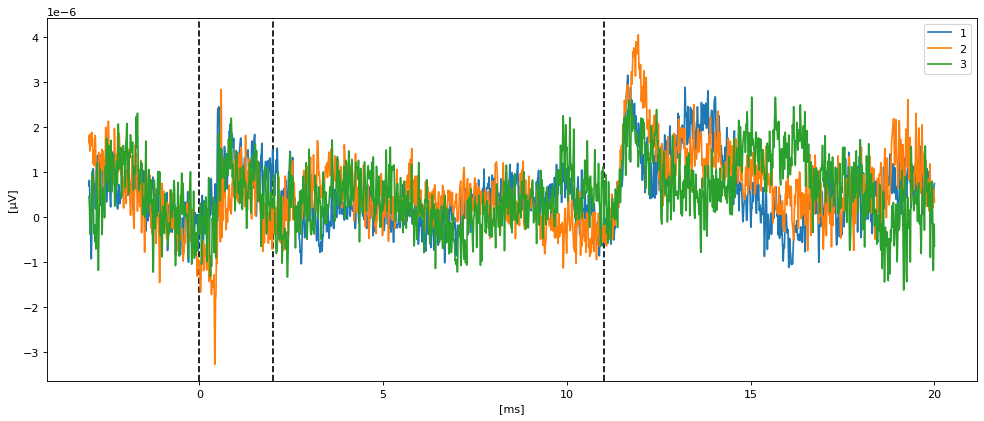

In [6]:
cda_all = dict()

for cond in cda_dict[list(cda_dict.keys())[0]].keys():
    cda_all[cond] = dict()

    for f in cda_dict.keys():
        perf = 'good'
        ldict = cda_dict[f][cond]['Left']
        rdict = cda_dict[f][cond]['Right']
        if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):            
            cda_dict_cur = (cda_dict[f][cond]['Left'][perf] + cda_dict[f][cond]['Right'][perf])/2            
            cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), str(t)))
    
plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=11, color='k', linestyle='--')
plt.plot(times, cda_all['1'].mean(0), label='1')
plt.plot(times, cda_all['2'].mean(0), label='2')
plt.plot(times, cda_all['3'].mean(0), label='3')
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
plt.show()

# Display Clean

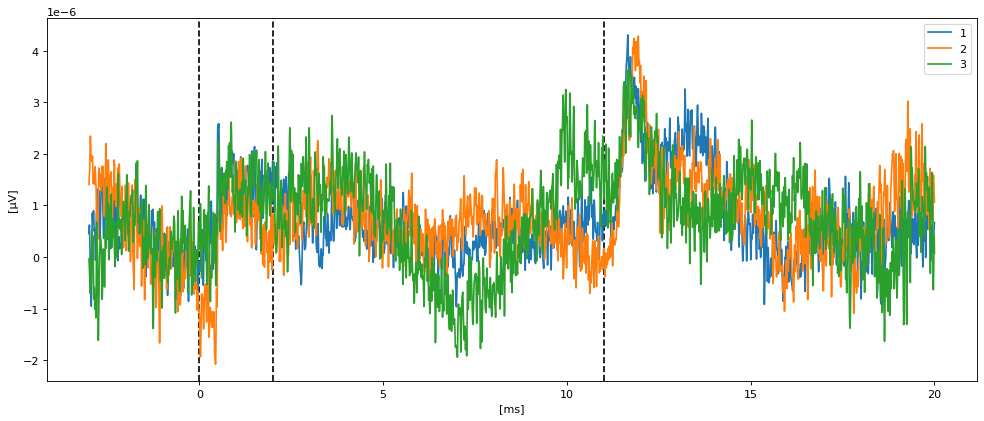

In [7]:
cda_all = dict()

for cond in cda_dict_clean[list(cda_dict_clean.keys())[0]].keys():
    cda_all[cond] = dict()

    for f in cda_dict_clean.keys():
        perf = 'good'
        ldict = cda_dict_clean[f][cond]['Left']
        rdict = cda_dict_clean[f][cond]['Right']
        if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):            
            cda_dict_cur = (cda_dict_clean[f][cond]['Left'][perf] + cda_dict_clean[f][cond]['Right'][perf])/2            
            cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), str(t)))
            
plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=11, color='k', linestyle='--')
plt.plot(times, cda_all['1'].mean(0), label='1')
plt.plot(times, cda_all['2'].mean(0), label='2')
plt.plot(times, cda_all['3'].mean(0), label='3')
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
plt.show()

# Plot Indexing Phase

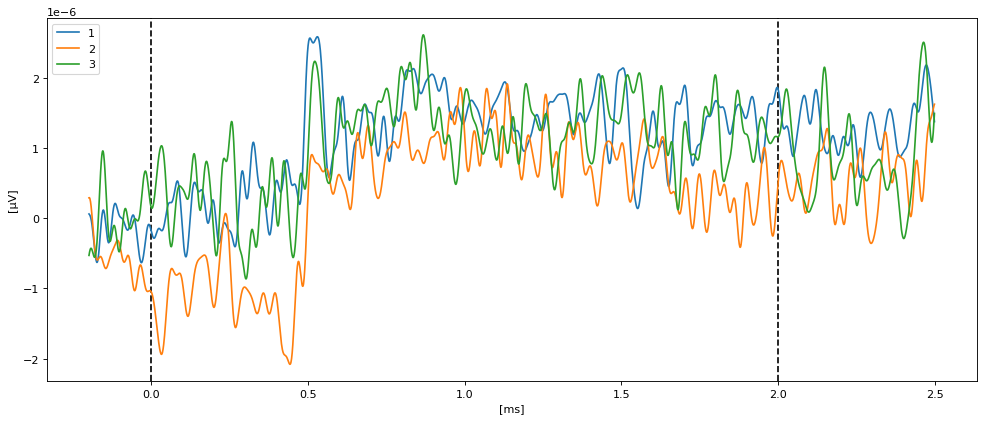

In [8]:
plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=2, color='k', linestyle='--')
#plt.axvline(x=11, color='k', linestyle='--')
plt.plot(times[(times > -0.2) & (times < 2.5)], cda_all['1'].mean(0)[(times > -0.2) & (times < 2.5)], label='1')
plt.plot(times[(times > -0.2) & (times < 2.5)], cda_all['2'].mean(0)[(times > -0.2) & (times < 2.5)], label='2')
plt.plot(times[(times > -0.2) & (times < 2.5)], cda_all['3'].mean(0)[(times > -0.2) & (times < 2.5)], label='3')
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
plt.show()

# Plot Tracking Phase

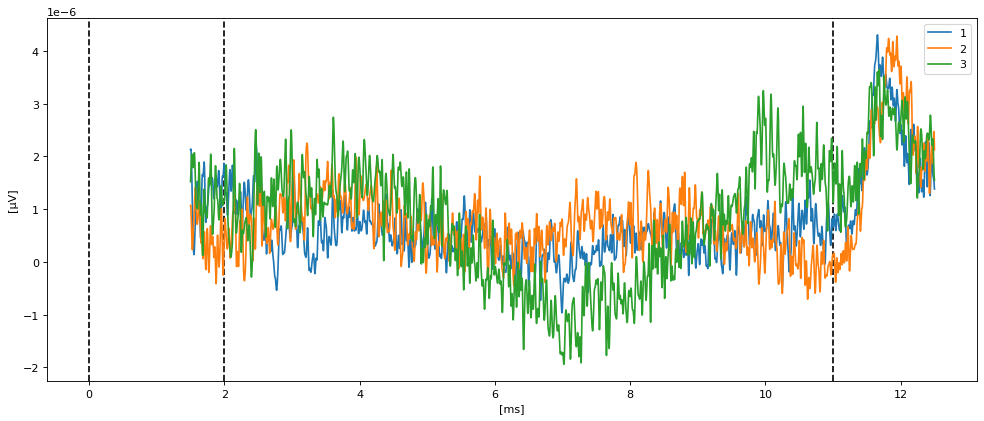

In [9]:
plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=11, color='k', linestyle='--')
plt.plot(times[(times > 1.5) & (times < 12.5)], cda_all['1'].mean(0)[(times > 1.5) & (times < 12.5)], label='1')
plt.plot(times[(times > 1.5) & (times < 12.5)], cda_all['2'].mean(0)[(times > 1.5) & (times < 12.5)], label='2')
plt.plot(times[(times > 1.5) & (times < 12.5)], cda_all['3'].mean(0)[(times > 1.5) & (times < 12.5)], label='3')
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
plt.show()

## Looking at Channels

In [10]:
chan_left_all =  ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1']
chan_right_all = ['Fp2', 'AF8', 'AF4', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

cda_dict = dict()
cda_all_channels = dict()
cda_all_channels_per_subj = dict()
for f in epochs_dict.keys():
    cda_all_channels_per_subj[f] = dict()
    for cond in conds:
        cda_all_channels[cond] = dict()
        cda_all_channels_per_subj[f][cond] = dict()
        for perf in perfs:
            cda_all_channels[cond][perf] = dict()
            cda_all_channels_per_subj[f][cond][perf] = dict()

# Get CDA per Channel-Pair
for i, ch in enumerate(chan_right_all):
    # Get CDA for a specific Channel-Pair for all Subjects
    for filename in epochs_dict.keys():
        cda_dict[filename] = get_CDA(epochs_dict[filename], conds, sides, perfs, [chan_right_all[i]], [chan_left_all[i]])

    # For each Cond-Perf get the CDA per Channel-Pair across Subjects
    cda_all = dict()
    for cond in cda_dict[list(cda_dict.keys())[0]].keys():
        cda_all[cond] = dict()
        
        for perf in ['good']: #perfs:
            cda_all[cond][perf] = dict()

            for f in cda_dict.keys():
                ldict = cda_dict[f][cond]['Left']
                rdict = cda_dict[f][cond]['Right']
                if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):
                    cda_dict_cur = (cda_dict[f][cond]['Left'][perf] + cda_dict[f][cond]['Right'][perf])/2
                    cda_all[cond][perf] = np.vstack([cda_all[cond][perf], cda_dict_cur]) if len(cda_all[cond][perf]) else cda_dict_cur
                    cda_all_channels_per_subj[f][cond][perf]["{}-{}".format(chan_left_all[i], chan_right_all[i])] = cda_dict_cur
                else:
                    print("==== SKIPPED: 0 points! (File: {} - Cond: {} - Perf: {})".format(str(f), str(cond), perf))
        
            cda_all_channels[cond][perf]["{}-{}".format(chan_left_all[i], chan_right_all[i])] = cda_all[cond][perf].mean(0)
            

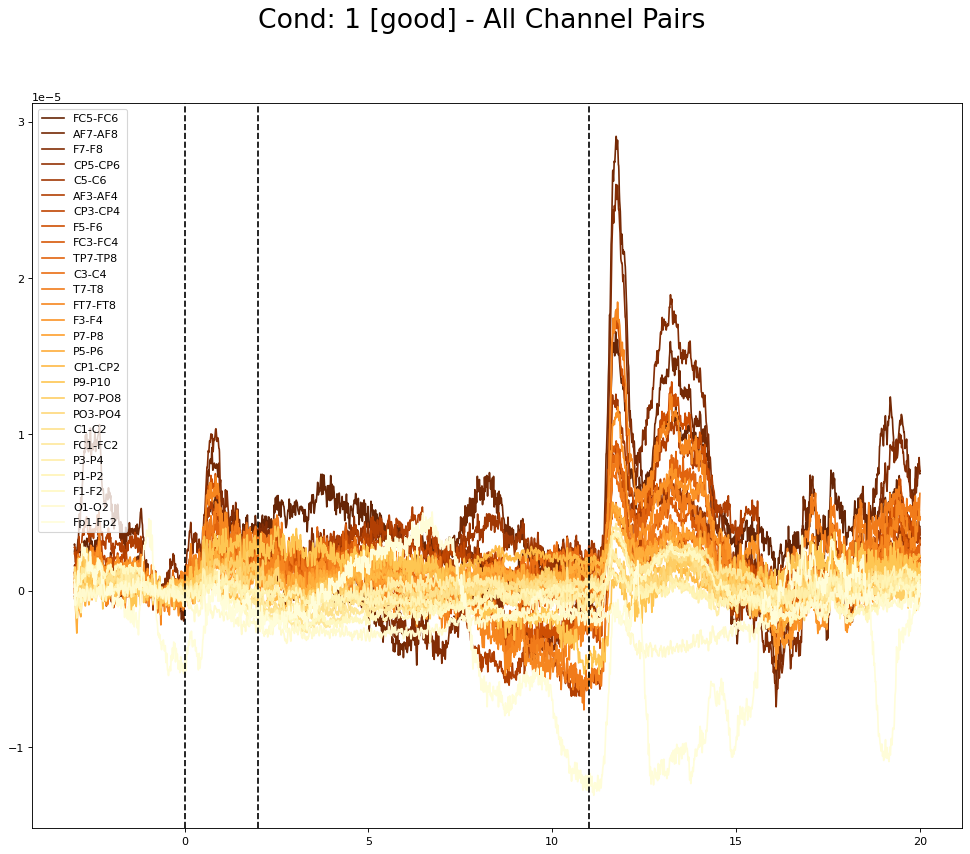

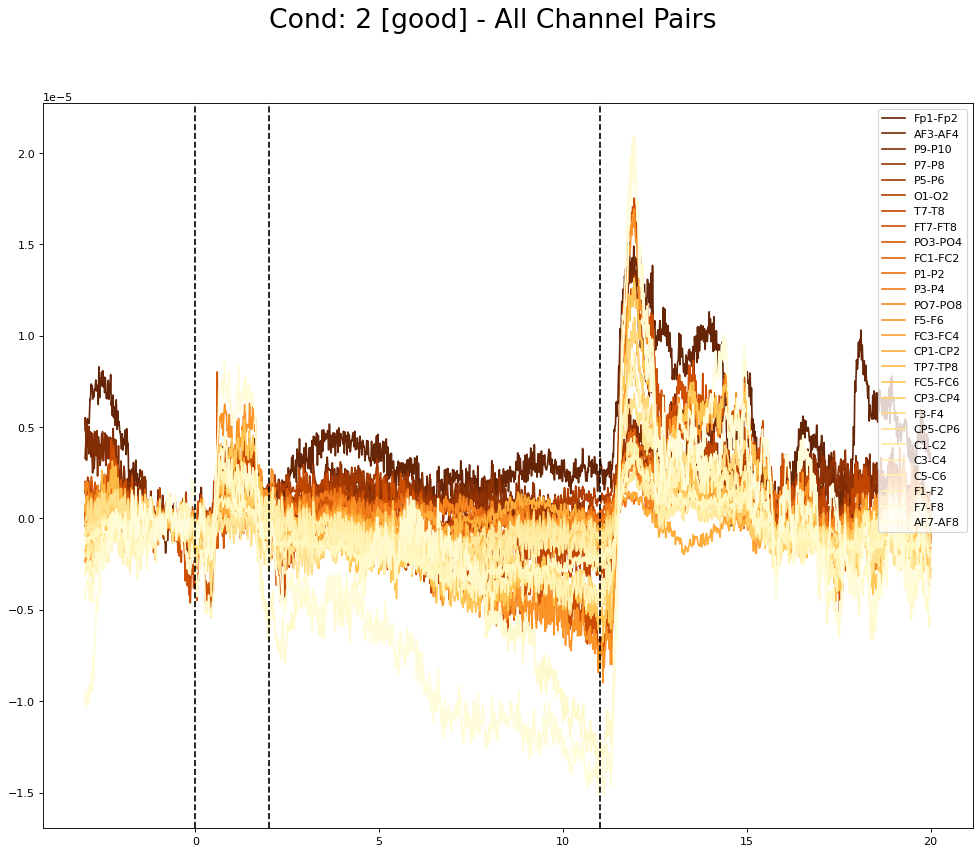

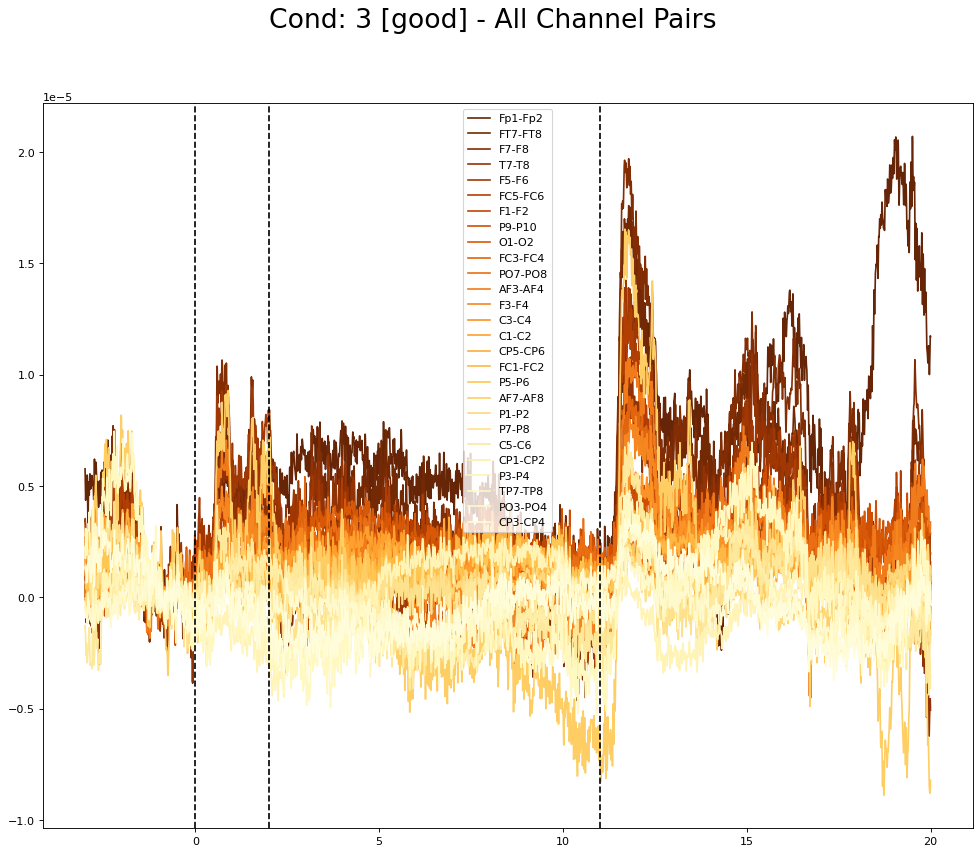

In [11]:
cmap = matplotlib.cm.get_cmap('YlOrBr')

for perf in ['good']:#perfs:
    for cond in conds:
        plt.figure(figsize=(15, 12), dpi=80)
        plt.suptitle("Cond: {} [{}] - All Channel Pairs".format(cond, perf), fontsize=24)

        ch_pair_mean_amp = [cda_all_channels[cond][perf][x].mean(0) for x in cda_all_channels[cond][perf]]
        mean_list, cda_sorted = zip(*sorted(zip(ch_pair_mean_amp, cda_all_channels[cond][perf].items()), reverse=True))

        nb_pairs = len(cda_all_channels[cond][perf].keys())
        for i, ch_pair in enumerate(cda_all_channels[cond][perf].keys()):
            plt.plot((times), cda_sorted[i][1], label=cda_sorted[i][0], color=cmap(1-i/nb_pairs))

        plt.axvline(x=0, color='k', linestyle='--')
        plt.axvline(x=2, color='k', linestyle='--')
        plt.axvline(x=11, color='k', linestyle='--')
        #plt.gca().invert_yaxis()
        plt.legend()
        plt.show()

## Looking at Channels per Subject

In [ ]:
cmap = matplotlib.cm.get_cmap('YlOrBr')

for f in cda_all_channels_per_subj.keys():
    if True:
    #if f in top5 or f in low5:
        for perf in ['good']:#perfs:
            for cond in conds:        
                if len(cda_all_channels_per_subj[f][cond][perf]) > 0:
                    plt.figure(figsize=(15, 12), dpi=80)
                    plt.suptitle("[{}] Cond: {} ({}) - All Channel Pairs".format(f, cond, perf), fontsize=24)

                    ch_pair_mean_amp = [cda_all_channels_per_subj[f][cond][perf][x].mean(0) for x in cda_all_channels_per_subj[f][cond][perf]]
                    mean_list, cda_sorted = zip(*sorted(zip(ch_pair_mean_amp, cda_all_channels_per_subj[f][cond][perf].items()), reverse=True))

                    nb_pairs = len(cda_all_channels_per_subj[f][cond][perf].keys())
                    for i, ch_pair in enumerate(cda_all_channels_per_subj[f][cond][perf].keys()):
                        plt.plot((times), cda_sorted[i][1], label=cda_sorted[i][0], color=cmap(1-i/nb_pairs))

                    plt.axvline(x=0, color='k', linestyle='--')
                    plt.axvline(x=2, color='k', linestyle='--')
                    plt.axvline(x=11, color='k', linestyle='--')
                    #plt.gca().invert_yaxis()
                    plt.legend()
                    plt.show()
                    #plt.savefig("./img/Villena-2019-Channels-{}-{}-{}.jpg".format(f, cond, perf), dpi=300)
                else:
                    print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), cond))